<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/docs/tutorials/kb_quality_control/python/kb_intro_1_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to single-cell RNA-seq I: pre-processing and quality control

This Python notebook demonstrates the use of the kallisto and bustools programs for pre-processing single-cell RNA-seq data ([also available as an R notebook](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_1_R.ipynb)). It streams in 1 million *C. elegans* reads, pseudoaligns them, and produces a *cells x genes* count matrix in about a minute. The notebook then performs some basic QC. It expands on a notebook prepared by Sina Booeshaghi for the Genome Informatics 2019 meeting, where he ran it in under 60 seconds during a 1 minute "lightning talk".

The [kallistobus.tools tutorials](https://www.kallistobus.tools/tutorials) site has a extensive list of follow-up tutorials and vignettes on single-cell RNA-seq.

In [1]:
#@title 
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/x-rNofr88BM" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


The notebook was written by A. Sina Booeshaghi and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publication, on which it is based:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285

##Setup

In [1]:
# This is  used to time the running of the notebook
# import time
# start_time = time.time()

### Install python packages

In [3]:
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
#%%capture
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy

In [4]:
# Install packages for analysis and plotting
from scipy.io import mmread
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.sparse import csr_matrix
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.figure_format = 'retina'

In [5]:
%%time
#%%capture
# `kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains the kallisto and bustools executables.
!pip install kb-python==0.24.1

     |████████████████████████████████| 35.4 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 12.4 MB/s eta 0:00:01     |███████████████████████████████▊| 4.8 MB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 3.5 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 34.6 MB 12.6 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /home/sebastien/kallistobustools/.env_scanpy/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-qlgzkkvk/loompy/setup.py'"'"'; __file__='"'"'/tmp/pip-install-qlgzkkvk/loompy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-u2bce6_j
       cwd: /tmp/pip-install-qlgzkkvk/loompy/
  Complete output (6 lines):
  usage: setup.py [global

### Download required files

In [6]:
%%time
# The quantification of single-cell RNA-seq with kallisto requires an index.
# Indices are species specific and can be generated or downloaded directly with `kb`.
# Here we download a pre-made index for C. elegans (the idx.idx file) along with an auxillary file (t2g.txt)
# that describes the relationship between transcripts and genes.
!wget -O idx.idx https://caltech.box.com/shared/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
!wget -O t2g.txt https://caltech.box.com/shared/static/cflxji16171skf3syzm8scoxkcvbl97x.txt

--2022-11-29 13:14:55--  https://caltech.box.com/shared/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
Resolving caltech.box.com (caltech.box.com)... 74.112.186.144
Connecting to caltech.box.com (caltech.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx [following]
--2022-11-29 13:14:55--  https://caltech.box.com/public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx [following]
--2022-11-29 13:14:55--  https://caltech.app.box.com/public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
Resolving caltech.app.box.com (caltech.app.box.com)... 74.112.186.144
Connecting to caltech.app.box.com (caltech.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 3

## Pseudoalignment and counting

In this notebook we pseudoalign 1 million *C. elegans* reads and count UMIs to produce a *cells x genes* matrix. Instead of being downloaded, the reads are streamed directly to the Google Colab notebook for quantification. 
See [this blog post](https://sinabooeshaghi.com/2019/07/09/fasterq-to-count-matrices-for-single-cell-rna-seq/) for more details on how the streaming works.

The data consists of a subset of reads from [GSE126954](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954) described in the paper:

* Packer, J., Zhu, Q. et al. [A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution](https://science.sciencemag.org/content/365/6459/eaax1971/tab-e-letters). Science (2019). doi:10.1126/science.aax1971

### Run kallisto and bustools

In [11]:
%%time
# This step runs `kb` to quantify the reads. `kb` can take as input URLs where the reads are located, and will stream the data
# to Google Colab where it is quantified as it is downloaded. This allows for quantifying very large datasets without first
# downloading them and saving them to disk. 

!kb count -i idx.idx -g t2g.txt --overwrite -x 10xv2 https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz

[2022-11-29 13:25:45,929]    INFO Piping https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz to tmp/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz
[2022-11-29 13:25:45,930]    INFO Piping https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz to tmp/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
[2022-11-29 13:25:45,932]    INFO Generating BUS file from
[2022-11-29 13:25:45,932]    INFO         tmp/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz
[2022-11-29 13:25:45,932]    INFO         tmp/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
[2022-11-29 13:26:28,513]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2022-11-29 13:26:29,683]    INFO Whitelist not provided
[2022-11-29 13:26:29,683]    INFO Copying pre-packaged 10XV2 whitelist to .
[2022-11-29 13:26:29,760]    INFO Inspecting BUS file tmp/output.s.bus
[2022-11-29 13:26:30,418]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2022-11-29 13:26:46,866]    INFO Sor

### Exercises

- `kb` can quantify data that is streamed from a URL as in the example above, or can read in data from disk. Is it faster to stream data, or to download it first and then quantify it from disk?

In [8]:
!kb --help

usage: kb [-h] [--list] <CMD> ...

kb_python 0.24.1

positional arguments:
  <CMD>
    info      Display package and citation information
    ref       Build a kallisto index and transcript-to-gene mapping
    count     Generate count matrices from a set of single-cell FASTQ files

optional arguments:
  -h, --help  Show this help message and exit
  --list      Display list of supported single-cell technologies


In [8]:
# %%time
# !wget https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz 
# !wget https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
# !kb count -i idx.idx -g t2g.txt --overwrite -t 2 -x 10xv2 fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz

- The -t option in `kb` sets the numnber of threads to be used. The Google Colab machine you are running on has two threads. If you run this notebook locally you can increase the number of threads beyond 2. As the number of threads is increased the running time decreases proportionately, although eventually the speed at which reads can be loaded from disk is a limiting factor. Verify that running `kb` with 1 thread on Google Colab takes about twice as long as with 2 threads.

In [9]:
!kb count -h

usage: kb count [-h] [--keep-tmp] [--verbose] -i INDEX -g T2G -x TECHNOLOGY
                [-o OUT] [-w WHITELIST] [-t THREADS] [-m MEMORY] [-c1 T2C]
                [-c2 T2C] [--overwrite] [--lamanno | --filter [{bustools}]]
                [--loom | --h5ad]
                fastqs [fastqs ...]

Generate count matrices from a set of single-cell FASTQ files. Run `kb --list`
to view single-cell technology information.

positional arguments:
  fastqs                FASTQ files

optional arguments:
  -h, --help            Show this help message and exit
  --keep-tmp            Do not delete the tmp directory
  --verbose             Print debugging information
  -o OUT                Path to output directory (default: current directory)
  -w WHITELIST          Path to file of whitelisted barcodes to correct to. If
                        not provided and bustools supports the technology, a
                        pre-packaged whitelist is used. If not, the bustools
                        

In [10]:
%%time
!kb count -i idx.idx -g t2g.txt --overwrite -t 1 -x 10xv2 https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz

[2022-11-29 13:23:07,109]    INFO Piping https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz to tmp/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz
[2022-11-29 13:23:07,122]    INFO Piping https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz to tmp/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
[2022-11-29 13:23:07,123]    INFO Generating BUS file from
[2022-11-29 13:23:07,123]    INFO         tmp/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz
[2022-11-29 13:23:07,123]    INFO         tmp/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
[2022-11-29 13:23:51,014]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2022-11-29 13:23:52,231]    INFO Whitelist not provided
[2022-11-29 13:23:52,232]    INFO Copying pre-packaged 10XV2 whitelist to .
[2022-11-29 13:23:52,307]    INFO Inspecting BUS file tmp/output.s.bus
[2022-11-29 13:23:53,014]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2022-11-29 13:24:11,386]    INFO Sor

## Basic QC 

### Represent the cells in 2D

In [13]:
# Read in the count matrix that was output by `kb`.
mtx = mmread("counts_unfiltered/cells_x_genes.mtx")

In [14]:
# Perform SVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(mtx)
X = tsvd.transform(mtx)

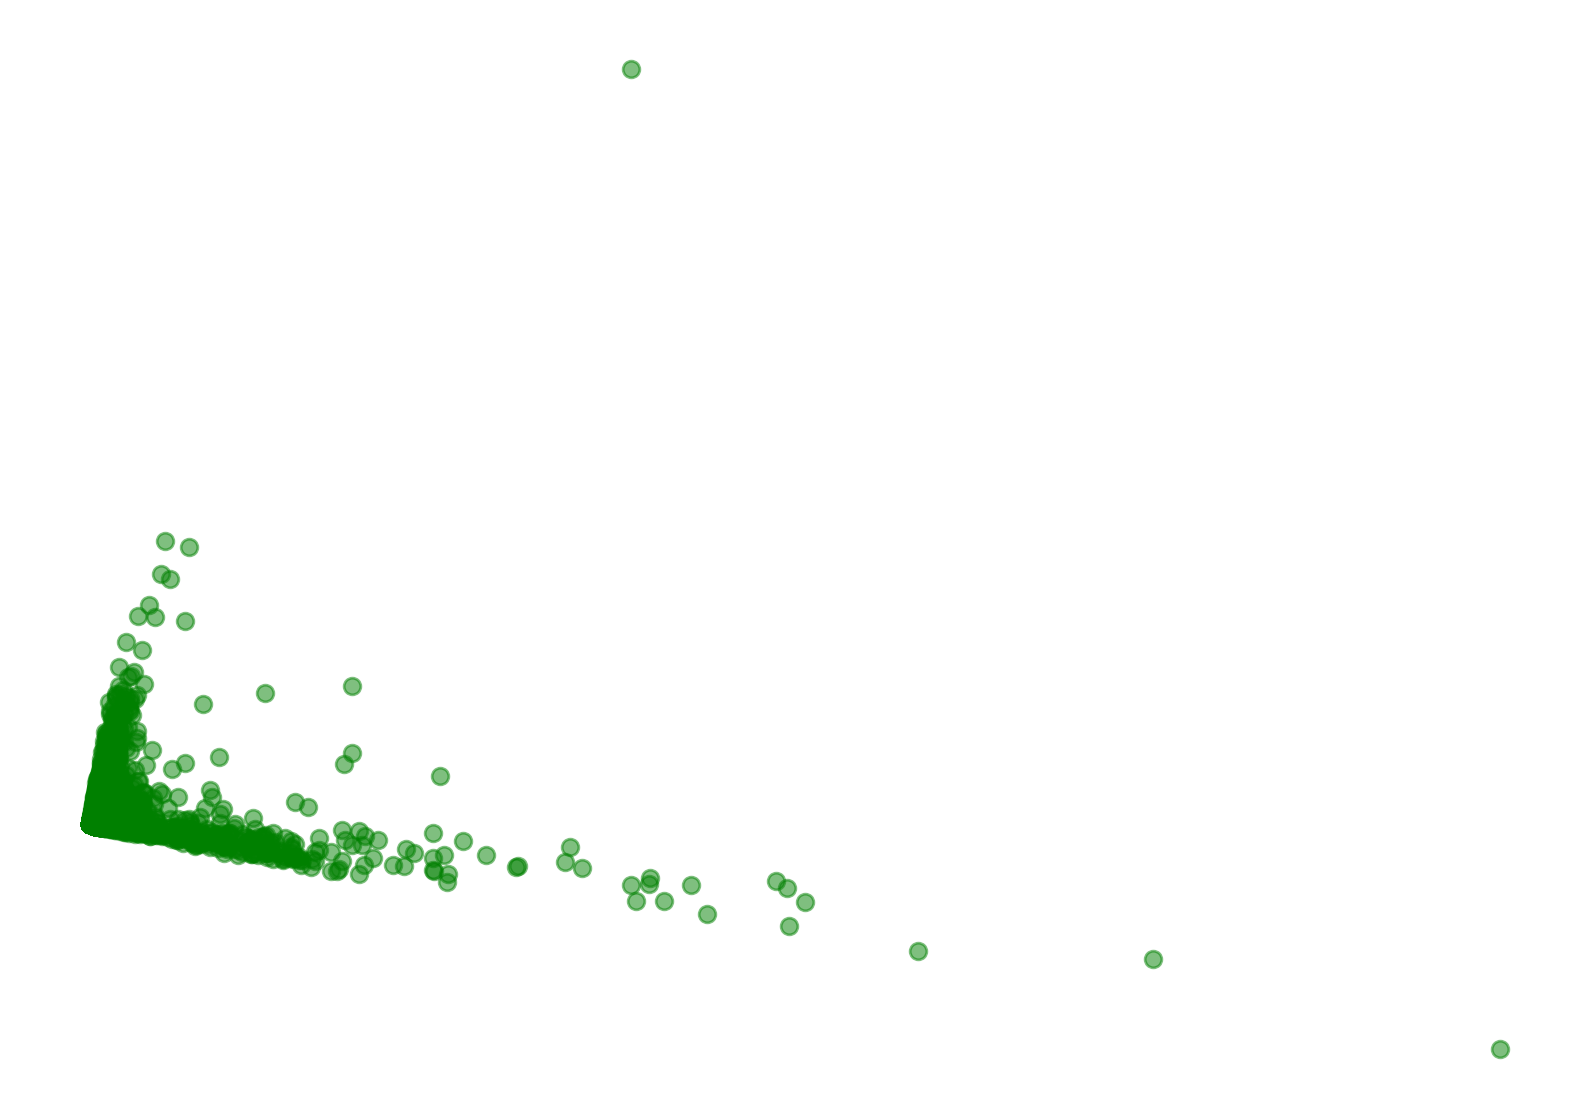

In [24]:
# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off');

While the PCA plot shows the overall structure of the data, a visualization highlighting the density of points reveals a large number of droplets represented in the lower left corner.


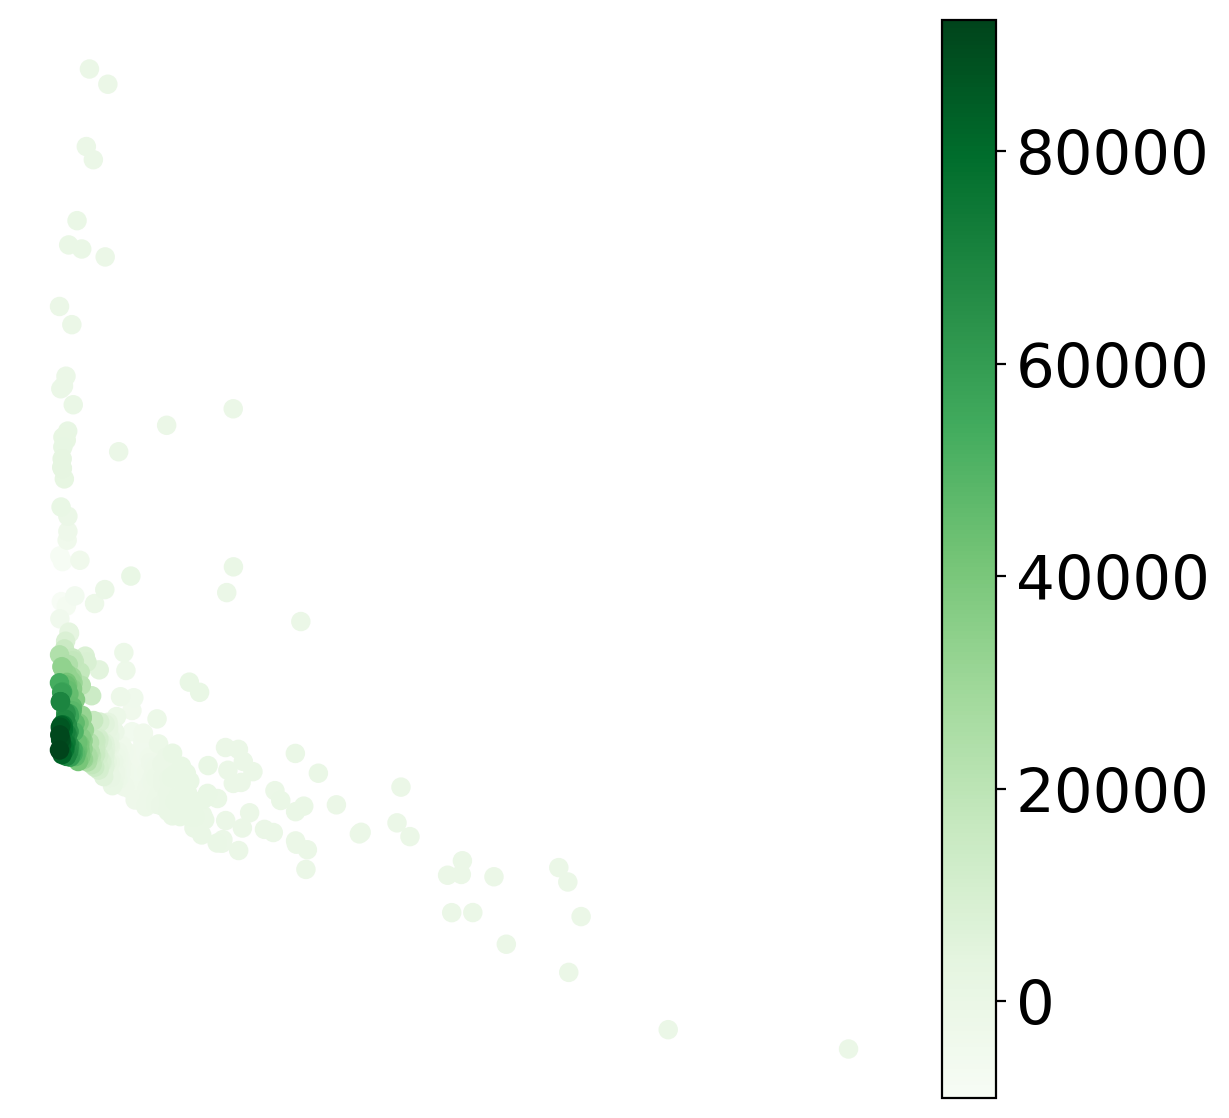

In [23]:
# density display for PCA plot
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    sc = ax.scatter( x, y, c=z, **kwargs )
    return sc

fig, ax = plt.subplots(figsize=(7,7))

x = X[:,0]
y = X[:,1]

sc = density_scatter(x, y, ax=ax, cmap="Greens")

fig.colorbar(sc, ax=ax)
plt.axis('off');

The following plot helps clarify the reason for the concentrated points in the lower-left corner of the PCA plot.

In [17]:
# Create sparse matrix representation of the count matrix
mtx = csr_matrix(mtx)

### Test for library saturation

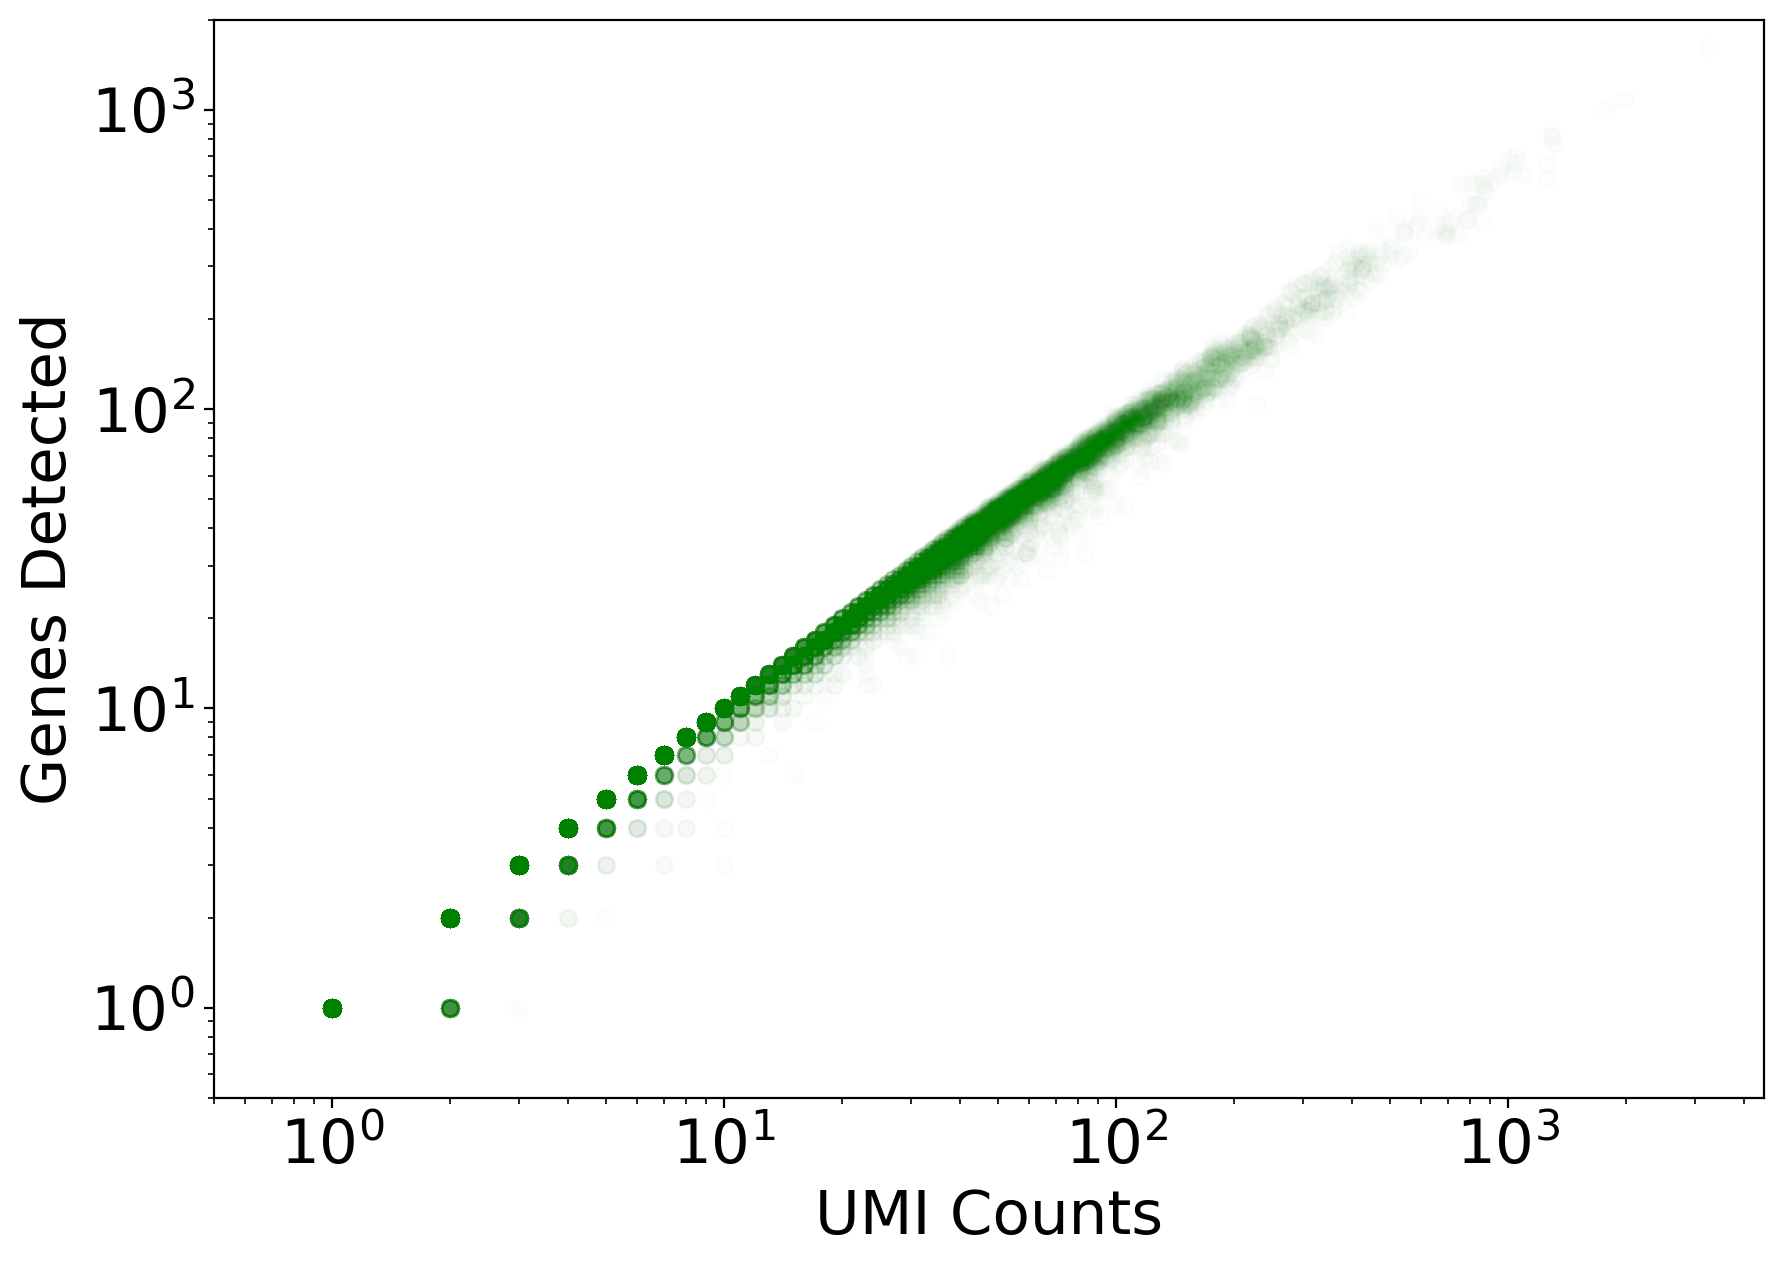

In [25]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1))[:,0], np.asarray(np.sum(mtx>0, axis=1))[:,0], color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000));

Here we see that there are a large number of near empty droplets. A useful approach to filtering out such data is the "knee plot" shown below.

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

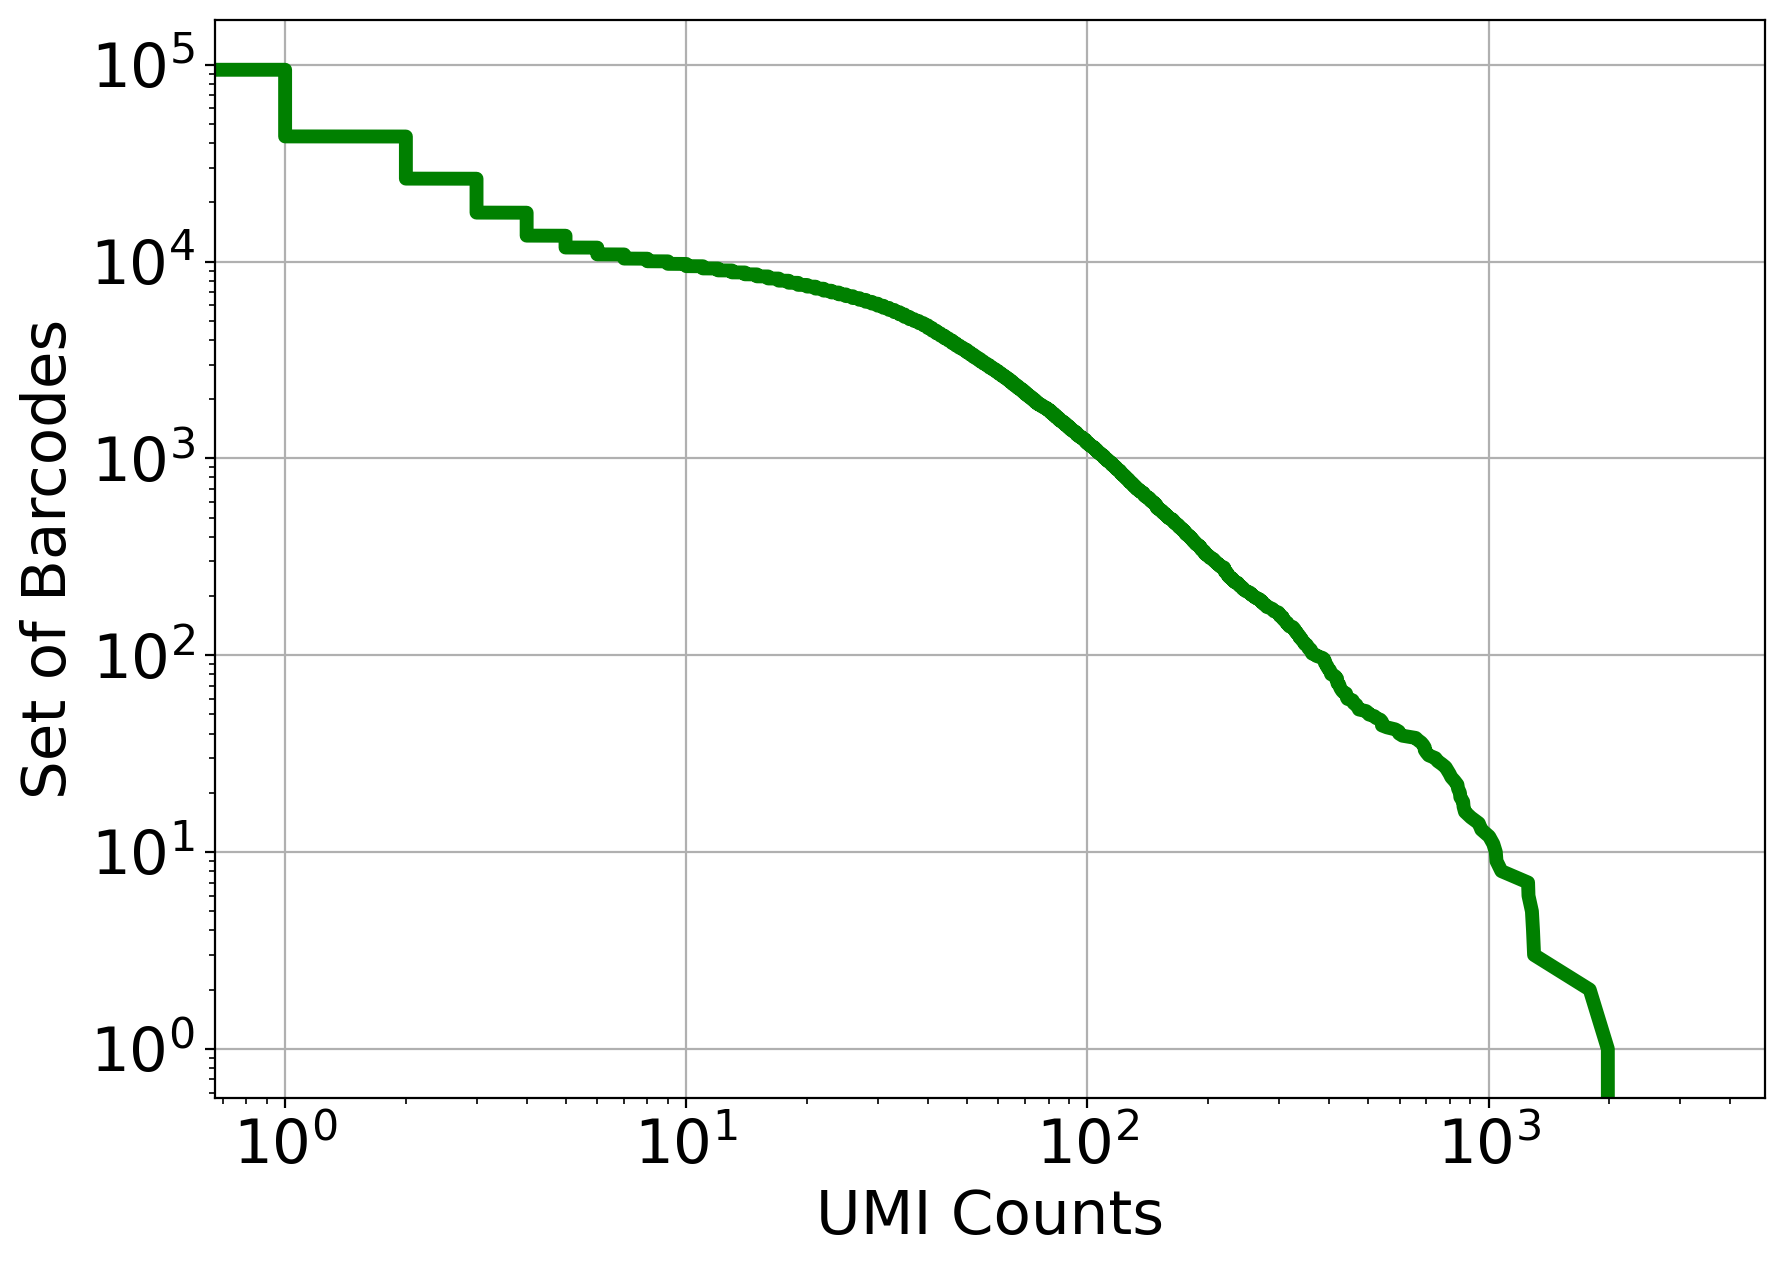

In [21]:
# Create the "knee plot"
knee = np.sort((np.array(mtx.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)),linewidth=5, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="major")


In [17]:
# An option is to filter the cells and genes by a threshold
# row_mask = np.asarray(mtx.sum(axis=1)>30).reshape(-1)
# col_mask = np.asarray(mtx.sum(axis=0)>0).reshape(-1)
# mtx_filtered = mtx[row_mask,:][:,col_mask]

### Exercises

- The "knee plot" is sometimes shown with the UMI counts on the y-axis instead of the x-axis, i.e. flipped and rotated 90 degrees. Make the flipped and rotated plot. Is there a reason to prefer one orientation over the other?

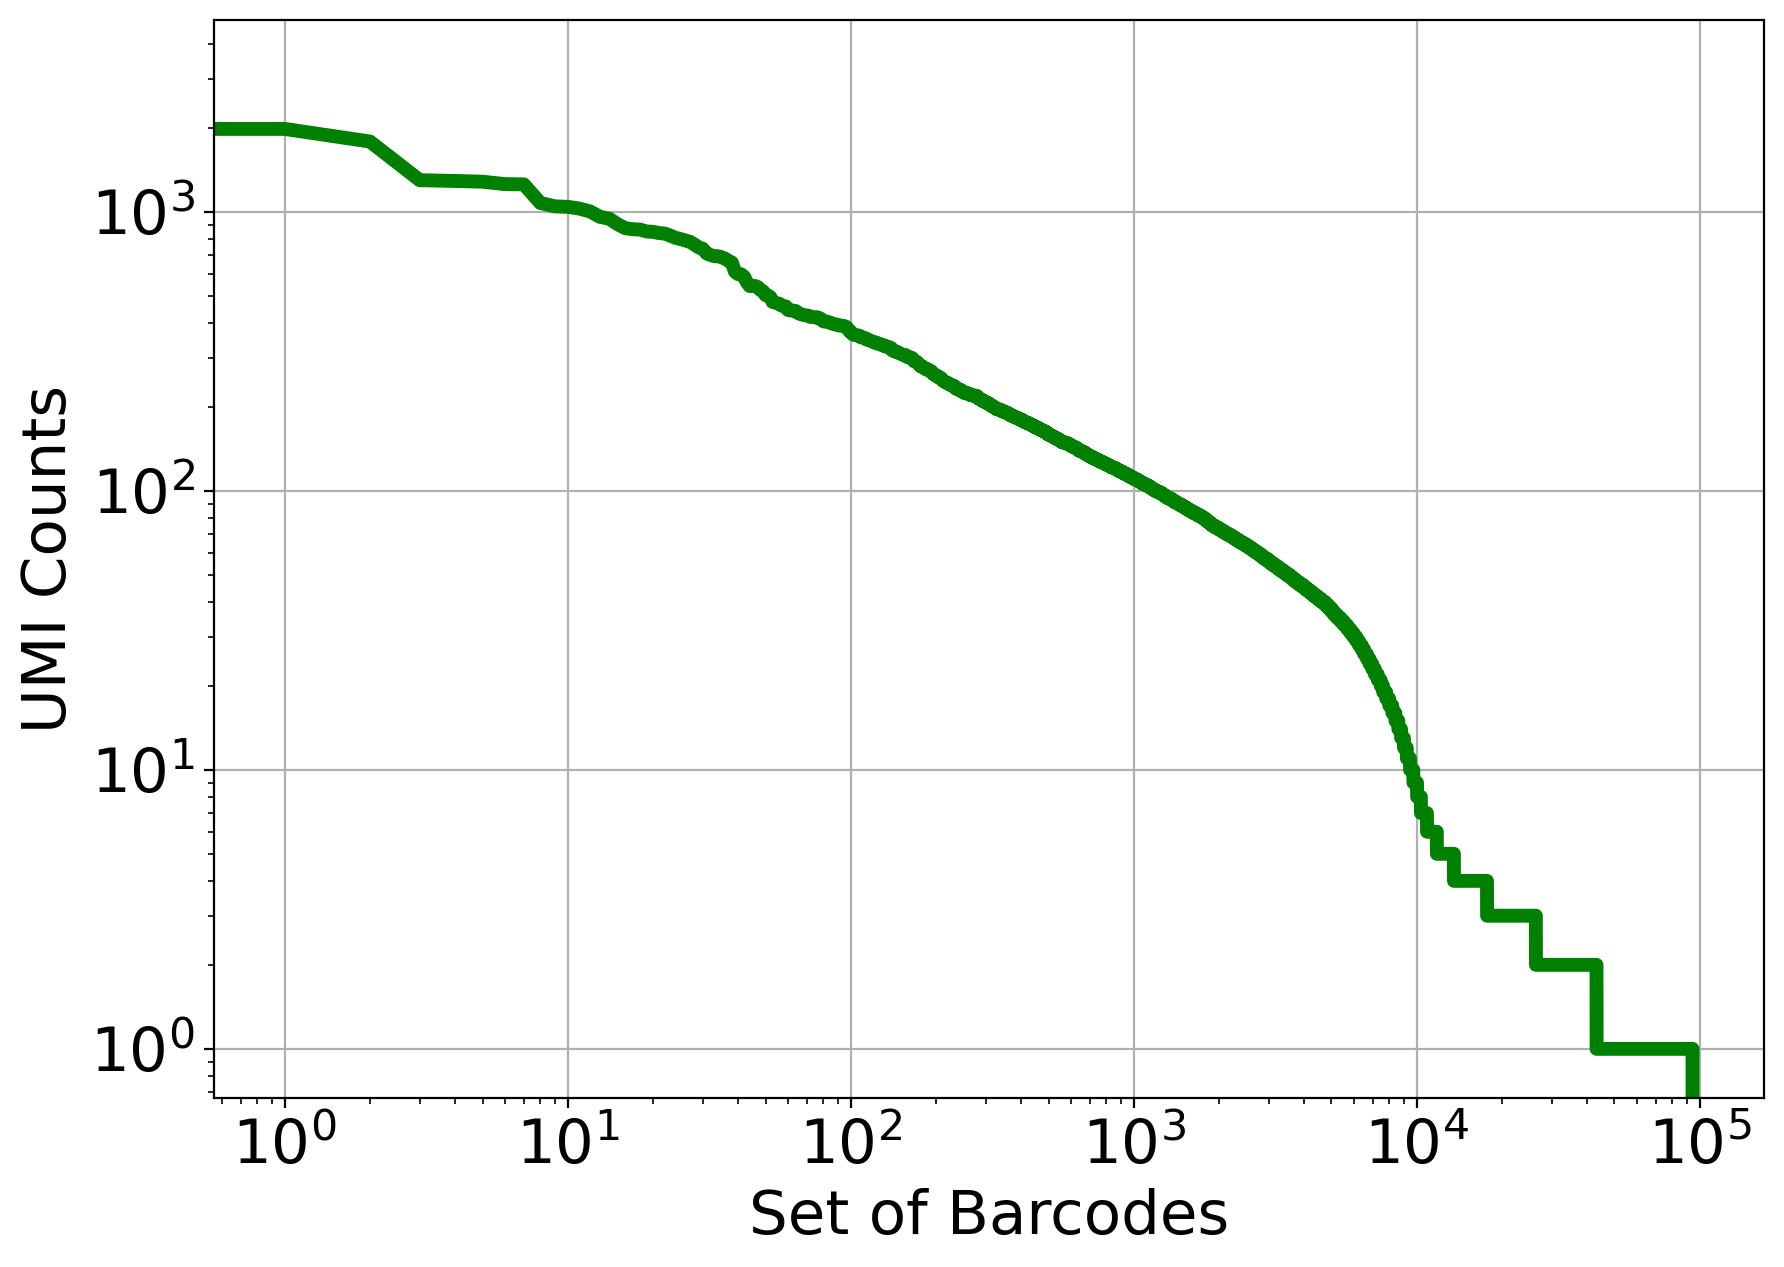

In [27]:
# Create the flipped and rotated "knee plot"
knee = np.sort((np.array(mtx.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(range(len(knee)), knee,linewidth=5, color="g")

ax.set_xlabel("Set of Barcodes")
ax.set_ylabel("UMI Counts")

plt.grid(True);


For more information on this exercise see [Rotating the knee (plot) and related yoga](https://liorpachter.wordpress.com/2019/06/24/rotating-the-knee-plot-and-related-yoga/).

- The PCA subspaces form a [*flag*](https://en.wikipedia.org/wiki/Flag_(linear_algebra). This means, for example, that regardless of the number of dimensions chosen for the PCA dimensionality reduction, the 2D subspace remains the same. Verify this empirically. 

- As you increase the number of dimensions for the PCA reduction, you can also view the relationship between different suspaces. Explore this by changing the subspace dimensions visualized.



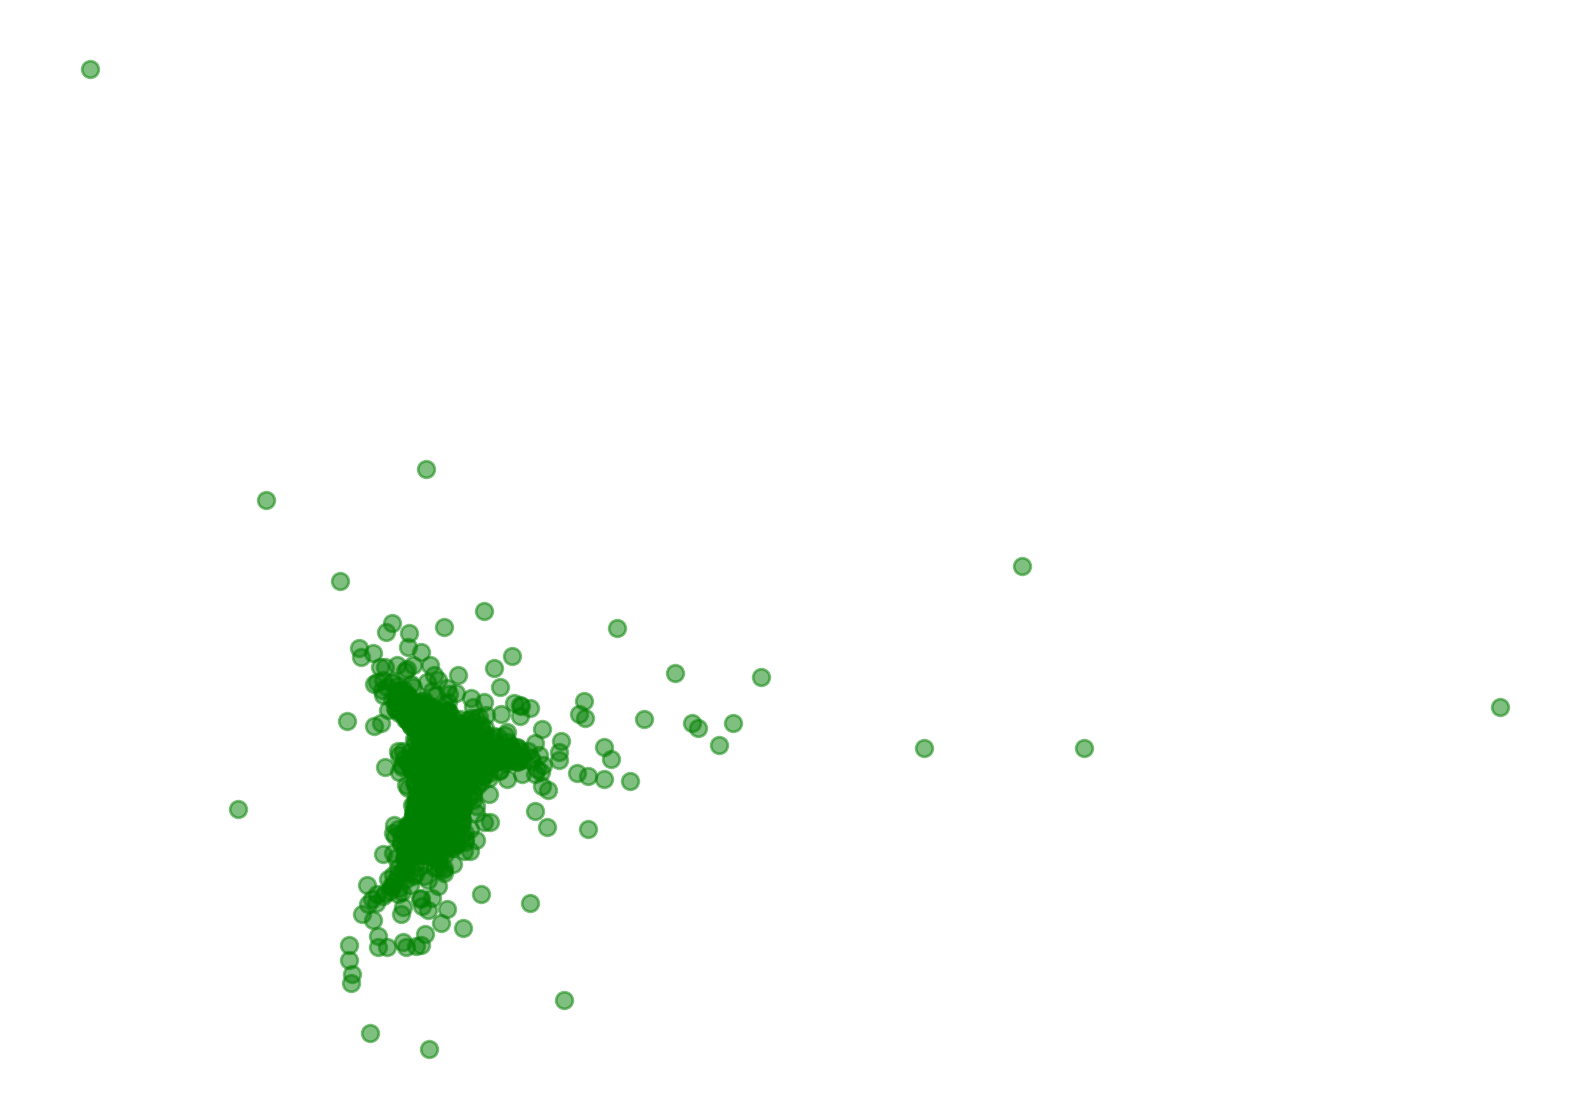

In [33]:
#@title Exploring PCA subspsaces { run: "auto", vertical-output: true, display-mode: "both" }
n_components =  5#@param {type:"integer"}
dimension_A =  4#@param {type:"integer"}
dimension_B =  3#@param {type:"integer"}
# Perform SVD
tsvd = TruncatedSVD(n_components)
tsvd.fit(mtx)
X = tsvd.transform(mtx)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,dimension_A-1], X[:,dimension_B-1], alpha=0.5, c="green")

plt.axis('off');

## Discussion

This notebook has demonstrated the pre-processing required for single-cell RNA-seq analysis. `kb` is used to pseudoalign reads and to generate a *cells x genes* matrix. Following generation of a matrix, basic QC helps to assess the quality of the data.

In [34]:
# Running time of the notebook
#print("{:.2f} seconds".format((time.time()-start_time)))

**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/).